<h1 div class='alert alert-success'><center> Tunning Hyperparameters Classificador SGD

 </center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  0. IMPORTAÇÕES </div>

In [58]:
!pip install --quiet optuna
!pip install --q GPUtil
#!pip install --q pytorch-tabnet

## 0.1. Bibliotecas

In [1]:
import warnings
import os
import gc
import random
import glob
import optuna

In [25]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt 
import seaborn              as sns
import joblib               as jb

In [26]:
import torch
import torch.nn             as nn

In [27]:
from sklearn.linear_model import SGDClassifier

In [28]:
from sklearn.model_selection       import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing         import QuantileTransformer,  KBinsDiscretizer, StandardScaler
from sklearn.preprocessing         import RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn                       import metrics
from sklearn.feature_selection     import SelectKBest, SelectPercentile, f_classif

In [29]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner

In [30]:
from GPUtil                        import showUtilization as gpu_usage
from numba                         import cuda
from sklearn.ensemble              import IsolationForest
from psutil                        import virtual_memory
from datetime                      import datetime
from BorutaShap                    import BorutaShap

## 0.2. Funções

In [31]:
def jupyter_setting():
    
    %matplotlib inline
     
    pd.options.display.max_columns = None
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
      
    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    #pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

In [32]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [34]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [36]:
def graf_corr(df):
    
    df = df.corr().round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(16,16))
    ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [37]:
def correlation(dataset, threshold):

    col_corr    = set()  # Conjunto de todos os nomes de colunas correlacionadas
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # estamos interessados no valor coeficiente absoluto
                colname = corr_matrix.columns[i]        # obtendo o nome da coluna
                col_corr.add(colname)
    
    return col_corr

In [38]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

## 0.3. GPU

### 0.3.1. Informações

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 15 20:02:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.06       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    N/A /  N/A |    702MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 0.3.2. Memória

In [17]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


## 0.4. Carregar Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
path   = '/content/drive/MyDrive/kaggle/10 - Outubro/'
path   = ''
target = 'target'

In [19]:
df3_train     = jb.load(path + 'Data/pkl/df2_nb_02_train.pkl.z')
df3_test      = jb.load(path + 'Data/pkl/df2_nb_02_test.pkl.z')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df3_train.shape, df3_test.shape, df_submission.shape

((600000, 111), (540000, 110), (540000, 2))

In [20]:
df3_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,1,0,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,1,0,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,0,1,3.814453,0.124084,-0.520020,233.5000,9.609375
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901

In [21]:
df3_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,1,0,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,1,0,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,0,1,3.814453,0.124084,-0.520020,233.5000,9.609375
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901

# <div class="alert alert-success"> 1.  TUNNING </div>

## 1.0. Split Train/Test

In [40]:
X      = df3_train.drop([target], axis=1)    
y      = df3_train[target].copy()
X_test = df3_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 0)

del df3_train , df3_test

free_gpu_cache() 

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((480000, 110), (480000,), (120000, 110), (120000,))

## 1.1. Classe Tunning 

In [168]:
class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model import RidgeClassifier
    
    def __init__(self, name_model, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_         
        self.feature     = feature_
        self.seed        = seed_
        self.scaler      = scaler_
        self.feature_bin = feature_bin_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', 
                                train_shape_row=0, test_shape_row=0): 
    
        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'
        
        paths = ['model/preds/test/n1', 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''
            
        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '\\', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl
                        
                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl
                
                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y
        
        return X_train_pred_nivel_1, X_test_pred_nivel_1
    
    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model, name_model_, X_, y_, X_ts_, scaler_=None, feature_bin_= None, 
                                         feature_imp_num=5, seed_=12359):

        TunningModels.delete_files(name_model_)
    
        mdl ,score , y_hat = TunningModels.cross_valid( model        = model, 
                                                        model_name_  = name_model_, 
                                                        X_           = X_, 
                                                        y_           = y_, 
                                                        X_test_      = X_ts_, 
                                                        type_model   = 1, 
                                                        feature      = None,
                                                        seed         = seed_, 
                                                        tunning      = 1, 
                                                        scaler       = scaler_,
                                                        print_result = False, 
                                                        feature_bin  = feature_bin_, 
                                                        save_predict = False,
                                                        n_splits     = 2
                                                        )
        
        df               = pd.DataFrame()
        df["feature"]    = X_.columns.to_list()
        df["importance"] = mdl.feature_importances_
        
        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()
        
        print(feature_import)
        print()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)

            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model_ + '_' + str(i+1)   

                feature_sample.append(feature_imp)

                feature_sample_bin = []

                for x in feature_sample: 
                    if x in feature_bin_: 
                        feature_sample_bin.append(x)

                if len(feature_sample_bin)==0:
                    feature_sample_bin = None
                
                mdl ,score , y_hat = TunningModels.cross_valid( model        = model, 
                                                                model_name_  = name_model_xgb_div, 
                                                                X_           = X_, 
                                                                y_           = y_, 
                                                                X_test_      = X_ts_, 
                                                                type_model   = 2, 
                                                                feature      = feature_sample,
                                                                seed         = seed_, 
                                                                tunning      = 1, 
                                                                scaler       = scaler_,
                                                                print_result = False, 
                                                                feature_bin  = feature_sample_bin, 
                                                                save_predict = True,
                                                                n_splits     = 3
                                                                )
                
                if score >=.6:
                    create = '*'
                else: 
                    create = ' '
            
                feature_best.append(feature)
                print('Score: {:2.5f} => {} Gr.Feature: {} {}'.format(score, create, i+1, feature_sample))

            print('')
            
        print('')
        print('FIM')
        print('')
        
    def model_of_diversity_feature_one_(model, name_model,  X_, y_, X_test_,  scaler_=None, feature_bin_=None, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)
        print()

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            mdl ,score , y_hat = TunningModels.cross_valid(model       = model, 
                                              model_name_  = name_model_xgb_div, 
                                              X_           = X_, 
                                              y_           = y_, 
                                              X_test_      = X_test_, 
                                              type_model   = 1, 
                                              feature      = feature,
                                              seed         = seed_, 
                                              tunning      = 1, 
                                              scaler       = scaler_,
                                              print_result = False, 
                                              feature_bin  = feature_bin_, 
                                              save_predict = True,
                                              n_splits     = 3
                                              )
    
            if score >.6:
                create = '*'
            else: 
                create = ' '
                
            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     
                            
                    mdl ,score , y_hat = TunningModels.cross_valid( model       = model, 
                                                                    model_name_  = name_model_xgb_div, 
                                                                    X_           = X_, 
                                                                    y_           = y_, 
                                                                    X_test_      = X_test_, 
                                                                    type_model   = 1, 
                                                                    feature      = [feature, feature_],
                                                                    seed         = seed_, 
                                                                    tunning      = 1, 
                                                                    scaler       = scaler_,
                                                                    print_result = False, 
                                                                    feature_bin  = feature_bin_, 
                                                                    save_predict = True,
                                                                    n_splits     = 3
                                                                    )
            
                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
    
    def save_data_model(model_, model_name_, path_, X_train_prob_, y_hat_test_, score_, seed_, level_='1'):
        
        level_ = 'n'+ level_ + '/'
        
        if score_>=.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(X_train_prob_, path_name_train)
            jb.dump(y_hat_test_, path_name_test)
            jb.dump(model_, path_name_model)
            jb.dump(pd.DataFrame([model_.get_params()]), path_name_param)   
            
            if score_>=.6:
                # Gerar o arquivo de submissão 
                df_submission['target'] = y_hat_test_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)

    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def cross_valid(model, model_name_, X_, y_, X_test_, type_model=1, feature=None, 
                    seed=None, tunning=1, save_predict=False, threshold=.5, n_splits=5, 
                    scaler=StandardScaler(), level_='1', feature_bin=None, print_result=True):

        time_s = datetime.now()
    
        n_repeats    = 1
        y_hat_test   = None
        X_train_prob = []
        auc          = []
        lloss        = []
        f1           = []
        best_ntree   = []
        n_estimators = 1
        random       = str(np.random.rand(1)[0]).replace('.','')
        model_name_  = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'  
        
        if feature!=None:         
            X_      = X_[feature]
            X_test_ = X_test_[feature]
        
        # https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn        
        kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
           
        clf_name     = model.__class__.__name__

        num_parallel_tree = 1  
        n_estimators      = 1 * num_parallel_tree
        max_depth         = model.get_params()['max_iter'] 
        learning_rate     = 1 
                        
        if print_result:
            msg = 'Training model: {} seed {} - n_estimators: {} - max_iter: {} - {:2.5f} - {}'
            print('='*100)            
            print(msg.format(clf_name, seed, n_estimators, max_depth, learning_rate, contador))
            print('='*100)
        
        score = 0 
        
        free_gpu_cache()        

        for fold, (train_idx, valid_idx) in enumerate(kf.split(X_, y_, groups=y_)): 
            
            time_start = datetime.now()

            # Obtenha os dados de treino e 
            # validação através de indice
            X_trn, y_trn = X_.iloc[train_idx], y_.iloc[train_idx]
            X_val, y_val = X_.iloc[valid_idx], y_.iloc[valid_idx]
        
            if feature_bin!=None: 
                disc = KBinsDiscretizer(n_bins=50, encode='ordinal',strategy='uniform')
                X_trn[feature_bin]   = disc.fit_transform(pd.DataFrame(X_trn[feature_bin]))
                X_val[feature_bin]   = disc.fit_transform(pd.DataFrame(X_val[feature_bin]))

            # Scaler       
            if scaler!=None:                
                X_trn  = pd.DataFrame(scaler.fit_transform(pd.DataFrame(X_trn)), columns=X_trn.columns) 
                X_val  = pd.DataFrame(scaler.fit_transform(pd.DataFrame(X_val)), columns=X_trn.columns)
                
            model = model.fit(X_trn, y_trn)
        
            best_ntree_ = 1
            best_ntree.append(best_ntree_)
                
            # Predição na validação
            y_hat_val_prob = model.predict_proba(X_val)[:, 1] #   
            y_hat_val      = (y_hat_val_prob > threshold).astype(int) 

            X_train_prob.extend(y_hat_val_prob)
                        
            # Métricas 
            auc_      = metrics.roc_auc_score(y_val, y_hat_val_prob)                    
            f1_score_ = metrics.f1_score(y_val, y_hat_val)        
            log_loss_ = metrics.log_loss(y_val, y_hat_val_prob)
            
            # Salvar as métricas
            auc.append(auc_)
            f1.append(f1_score_)
            lloss.append(log_loss_)
                        
            # 1 / n_splits das previsões de saída.
            if y_hat_test is None:                    
                y_hat_test   = model.predict_proba(pd.DataFrame(X_test_))[:, 1]        
            else:        
                y_hat_test  += model.predict_proba(pd.DataFrame(X_test_))[:, 1]

            stop = ' '
            
            if n_estimators > best_ntree_: 
                stop = '*'               
            
            elapsed  = TunningModels.diff(time_start, datetime.now())

            if print_result:
                best_ntree_s = str(best_ntree_) + ((5-len(str(best_ntree_))) * ' ')  
                msg = 'Fold {}/{} AUC: {:2.5f} - F1: {:2.5f} - L. loss: {:2.5f} {} {} {}'
                print(msg.format(fold+1, n_splits*n_repeats, auc_, f1_score_, log_loss_, 
                                 stop, best_ntree_s, elapsed))
            
            del X_trn, y_trn, X_val, y_val              
            gc.collect()
          
        del  X_, y_, X_test_ 
        gc.collect()
        
        y_hat_test      /= (n_splits*n_repeats)
        score           = np.mean(auc)
        auc_mean        = np.mean(auc)
        auc_std         = np.std(auc)
        lloss_mean      = np.mean(lloss)
        f1_mean         = np.mean(f1)
        f1_std          = np.std(f1)
        best_ntree_mean = int(np.mean(best_ntree))
        msg             = '[Mean Fold]  AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. Loss: {:.5f} * {} {}'
        
        if save_predict:
            TunningModels.save_data_model(model_        = model, 
                                          model_name_   = model_name_, 
                                          path_         = path, 
                                          X_train_prob_ = X_train_prob, 
                                          y_hat_test_   = y_hat_test, 
                                          score_        = score, 
                                          seed_         = seed, 
                                          level_        = level_ 
                                          )                

        elapsed  = TunningModels.diff(time_s, datetime.now())

        if print_result:
            print('-'*100)
            print(msg.format(auc_mean, auc_std, f1_mean, lloss_mean, best_ntree_mean, elapsed))
            print('='*100)
            print('')

        del X_train_prob, 
        free_gpu_cache()
        
        return model, score, y_hat_test
       
    def sgb(self, trial):
                       
        params = {'loss'             : trial.suggest_categorical('loss', ['modified_huber', 'log']),  
                  'penalty'          : trial.suggest_categorical('penalty', ['l2', 'l2']),                   
                  'max_iter'         : trial.suggest_int('max_iter', 700, 1000), 
                  'tol'              : trial.suggest_float('tol', 0.0001, 0.005),                                                       
                  'random_state'     : trial.suggest_int('random_state', self.seed, self.seed)
                }
         
        #if params.get('penalty')== 'l1': 
        #    params.update({'loss': trial.suggest_categorical('loss', ['None'])})
        #    params.update({'dual': trial.suggest_categorical('dual', ['False'])})
            
        mdl = SGDClassifier(**params) 
        
        _,score,_ = TunningModels.cross_valid(model            = mdl, 
                                              model_name_      = self.name_clf,
                                              X_               = self.X_trn, 
                                              y_               = self.y_trn,  
                                              X_test_          = self.X_ts,
                                              type_model       = 3, 
                                              feature          = self.feature,
                                              seed             = self.seed,
                                              scaler           = self.scaler,
                                              level_           = '1', 
                                              n_splits         = 5, 
                                              save_predict     = True,
                                              feature_bin      = self.feature_bin
                                             )
        
        print(params)
        print()

        return score

## 1.2. Classificador SGD
Neste primeiro momento vamos testar diversos scalers.  

In [107]:
feature_int = X_test.filter(regex=r'f[0-9]').columns.to_list()
idx_sample  = X.sample(frac=.1,random_state=12359,replace=False).index.to_list()

In [101]:
%%time 

SEED   = 12359  
params = {'loss'          : 'modified_huber',
          'penalty'       : 'l2',          
          'max_iter'      : 500,
          'random_state'  : SEED, 
          'n_jobs'        : -1
        }

scalers = [#None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=SEED)]

score_bast = 0 
score_bast = 0 

name_model_clf = 'sgb_' 
name_model     = name_model_clf + '001_scaler_' 

TunningModels.delete_files(name_model)

for scaler in scalers: 
    
    X_test_scaler = X_test.copy()
    
    if scaler!=None:
        disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
        X_test_scaler[feature_int] = disc.fit_transform(X_test_scaler[feature_int])
        X_test_scaler = pd.DataFrame(scaler.fit_transform(X_test_scaler), columns=X_test.columns)
        
    mdl = SGDClassifier(**params) 
        
    print(scaler)
    name_model_          = name_model + str(scaler).lower()[:4]
    model_002, score, _  = TunningModels.cross_valid(model          = mdl, 
                                                     model_name_    = name_model_, 
                                                     X_             = X, 
                                                     y_             = y, 
                                                     X_test_        = X_test_scaler, 
                                                     type_model     = 1, 
                                                     feature        = None,
                                                     seed           = SEED, 
                                                     tunning        = 3, # retorna modelo                   
                                                     scaler         = scaler,
                                                     feature_bin    = feature_int, 
                                                     save_predict   = True
                                                     )

    if score > score_bast: 
        score_bast  = score
        scaler_name = scaler
       
print()
print('Scaler best: {}'.format(scaler_name))
print('Score      : {:2.5f}'.format(score_bast))

StandardScaler()
Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_depth: 500 - 1.00000 - 1
Fold 1/5 AUC: 0.72680 - F1: 0.68964 - L. loss: 0.95594   1     0h 0m 23s
Fold 2/5 AUC: 0.72070 - F1: 0.67570 - L. loss: 0.81091   1     0h 0m 23s
Fold 3/5 AUC: 0.72665 - F1: 0.69322 - L. loss: 0.75607   1     0h 0m 27s
Fold 4/5 AUC: 0.72746 - F1: 0.68959 - L. loss: 0.86538   1     0h 0m 26s
Fold 5/5 AUC: 0.72568 - F1: 0.68888 - L. loss: 0.84305   1     0h 0m 23s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.72546(Std:0.00245) - F1: 0.68741 - L. Loss: 0.84627 * 1 0h 2m 18s

RobustScaler()
Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_depth: 500 - 1.00000 - 1
Fold 1/5 AUC: 0.71395 - F1: 0.58456 - L. loss: 1.16353   1     0h 0m 41s
Fold 2/5 AUC: 0.70201 - F1: 0.67140 - L. loss: 1.11522   1     0h 0m 29s
Fold 3/5 AUC: 0.69431 - F1: 0.67647 - L. loss: 1.31645   1     0h 0m 35s
Fold 4/5 AUC: 0.

In [103]:
%%time 

scalers = [StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=SEED)]

score_bast = 0 
name_model = name_model_clf + '002_scaler_' 
TunningModels.delete_files(name_model)

for scaler in scalers: 
    
    X_test_scaler = X_test.copy()
    
    if scaler!=None:        
        X_test_scaler = pd.DataFrame(scaler.fit_transform(X_test_scaler), columns=X_test.columns)
        
    mdl = SGDClassifier(**params)  
    
    print(scaler) 
    name_model_          = name_model + str(scaler).lower()[:4]
    model_002, score, _  = TunningModels.cross_valid(model          = mdl, 
                                                     model_name_    = name_model_, 
                                                     X_             = X, 
                                                     y_             = y, 
                                                     X_test_        = X_test_scaler, 
                                                     type_model     = 1, 
                                                     feature        = None,
                                                     seed           = SEED, 
                                                     tunning        = 3, # retorna modelo                   
                                                     scaler         = scaler, 
                                                     save_predict   = True
                                                     )

    if score > score_bast: 
        score_bast  = score
        scaler_name = scaler
       
print()
print('Scaler best: {}'.format(scaler_name))
print('Score      : {:2.5f}'.format(score_bast))

StandardScaler()
Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_depth: 500 - 1.00000 - 1
Fold 1/5 AUC: 0.72188 - F1: 0.68664 - L. loss: 0.89761   1     0h 0m 16s
Fold 2/5 AUC: 0.73467 - F1: 0.71407 - L. loss: 0.97825   1     0h 0m 19s
Fold 3/5 AUC: 0.72526 - F1: 0.69579 - L. loss: 0.81621   1     0h 0m 17s
Fold 4/5 AUC: 0.71441 - F1: 0.66665 - L. loss: 0.80065   1     0h 0m 15s
Fold 5/5 AUC: 0.72690 - F1: 0.69159 - L. loss: 0.84907   1     0h 0m 16s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.72462(Std:0.00661) - F1: 0.69095 - L. Loss: 0.86836 * 1 0h 1m 38s

RobustScaler()
Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_depth: 500 - 1.00000 - 1
Fold 1/5 AUC: 0.69713 - F1: 0.67516 - L. loss: 1.28053   1     0h 0m 52s
Fold 2/5 AUC: 0.69897 - F1: 0.68559 - L. loss: 1.35556   1     0h 0m 46s
Fold 3/5 AUC: 0.70161 - F1: 0.67157 - L. loss: 1.32584   1     0h 0m 48s
Fold 4/5 AUC: 0.

<div class="alert alert-info" role="alert">

**`NOTA:`** <br>
    
</div>

### 1.2.1. Tunning 
Nesta etapa de modelagem, vamos criar 20 modelos e salvá-los para a nossa `Stacking`.

In [106]:
SEED_  = [12359]
score_ = 0 
sc     = MinMaxScaler()

X_test_scaler = X_test.copy()
X_test_scaler = pd.DataFrame(sc.fit_transform(X_test), columns=X_test.columns)

X_test_scaler.shape

(540000, 110)

In [208]:
%%time
SEED       = 12359  
name_model = name_model_clf + '003_tun_'
n_trials_  = 20

TunningModels.delete_files(name_model)

# Inicialize a classe do modelo de otimização
modelOpt = TunningModels(name_model      = name_model, 
                            X_trn_          = X, 
                            y_trn_          = y, 
                            X_ts_           = X_test_scaler,                                     
                            feature_        = None,  
                            scaler_         = sc, 
                            seed_           = SEED, 
                            #feature_bin_    = feature_int
                        )

pruner = MedianPruner(n_startup_trials = 5,
                      n_warmup_steps   = 0,
                      interval_steps   = 1,
                      n_min_trials     = 5,
                      )

study = optuna.create_study(direction = 'maximize',
                            sampler   = optuna.samplers.TPESampler(seed=SEED),
                            pruner    = optuna.pruners.MedianPruner(n_warmup_steps=10),
                            #pruner    = pruner,
                            study_name= 'lsvn_tun'
                            ) 

study.optimize(modelOpt.sgb, n_trials=n_trials_)

score_seed = study.best_value 
params     = study.best_params 
path_name  = path + 'model/optuna/' + name_model + '_best_score_{:2.5f}.pkl.z'.format(score_seed) 

jb.dump(study, path_name)

if params.get('penalty')== 'l1': 
    params.update({'solver': 'liblinear'}) 

print('')    
print('Score     : {:2.5f}'.format(score_seed))
print('Seed      : {}'.format(SEED))
print('Parameters:\n\n{}'.format(params))
print('')

seed_best   = SEED
scare_best  = score_seed 
params_best = params

Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 825 - 1.00000 - 1
Fold 1/5 AUC: 0.74484 - F1: 0.71262 - L. loss: 0.75739   1     0h 0m 7s
Fold 2/5 AUC: 0.74498 - F1: 0.70765 - L. loss: 0.77314   1     0h 0m 7s
Fold 3/5 AUC: 0.74818 - F1: 0.70042 - L. loss: 0.73403   1     0h 0m 7s
Fold 4/5 AUC: 0.74573 - F1: 0.46235 - L. loss: 1.17367   1     0h 0m 7s
Fold 5/5 AUC: 0.74728 - F1: 0.73596 - L. loss: 0.73759   1     0h 0m 7s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74620(Std:0.00131) - F1: 0.66380 - L. Loss: 0.83516 * 1 0h 0m 50s

{'loss': 'modified_huber', 'penalty': 'l2', 'max_iter': 825, 'tol': 0.003830623154276751, 'random_state': 12359}

Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 962 - 1.00000 - 1
Fold 1/5 AUC: 0.74601 - F1: 0.52670 - L. loss: 0.96386   1     0h 0m 7s
Fold 2/5 AUC: 0.74560 - F1: 0.28383 - L. loss: 1.69132   1     0h 0m 7s
Fold 3/5 AUC: 0.

Fold 1/5 AUC: 0.74441 - F1: 0.53548 - L. loss: 0.99035   1     0h 0m 7s
Fold 2/5 AUC: 0.74512 - F1: 0.68080 - L. loss: 0.79430   1     0h 0m 7s
Fold 3/5 AUC: 0.74762 - F1: 0.73601 - L. loss: 0.72658   1     0h 0m 7s
Fold 4/5 AUC: 0.74627 - F1: 0.71936 - L. loss: 0.73212   1     0h 0m 7s
Fold 5/5 AUC: 0.74664 - F1: 0.72217 - L. loss: 0.84286   1     0h 0m 7s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74601(Std:0.00113) - F1: 0.67877 - L. Loss: 0.81724 * 1 0h 0m 51s

{'loss': 'modified_huber', 'penalty': 'l2', 'max_iter': 864, 'tol': 0.00453507321892875, 'random_state': 12359}

Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 759 - 1.00000 - 1
Fold 1/5 AUC: 0.74407 - F1: 0.66945 - L. loss: 0.61495   1     0h 0m 7s
Fold 2/5 AUC: 0.74381 - F1: 0.69537 - L. loss: 0.61269   1     0h 0m 7s
Fold 3/5 AUC: 0.74690 - F1: 0.67968 - L. loss: 0.61210   1     0h 0m 6s
Fold 4/5 AUC: 0.74431 - F1: 0.6711

Fold 1/5 AUC: 0.74558 - F1: 0.51146 - L. loss: 0.97956   1     0h 0m 12s
Fold 2/5 AUC: 0.74648 - F1: 0.50742 - L. loss: 1.00720   1     0h 0m 12s
Fold 3/5 AUC: 0.74962 - F1: 0.56013 - L. loss: 0.85382   1     0h 0m 14s
Fold 4/5 AUC: 0.74749 - F1: 0.51658 - L. loss: 1.01234   1     0h 0m 13s
Fold 5/5 AUC: 0.74859 - F1: 0.72974 - L. loss: 0.75127   1     0h 0m 12s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74755(Std:0.00144) - F1: 0.56507 - L. Loss: 0.92084 * 1 0h 1m 19s

{'loss': 'modified_huber', 'penalty': 'l2', 'max_iter': 926, 'tol': 0.0003923834338699613, 'random_state': 12359}

Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 914 - 1.00000 - 1
Fold 1/5 AUC: 0.74603 - F1: 0.67950 - L. loss: 0.74838   1     0h 0m 9s
Fold 2/5 AUC: 0.74604 - F1: 0.47258 - L. loss: 1.04173   1     0h 0m 9s
Fold 3/5 AUC: 0.74887 - F1: 0.59418 - L. loss: 0.82209   1     0h 0m 9s
Fold 4/5 AUC: 0.74622 - F1:

<div class="alert alert-info" role="alert">

**`NOTA:`** <br>
    
Com os melhores parametros gerei uma nova submissão e obtive a AUC de 0.68785.
    
</div>

### Análise 

In [209]:
###################################################################################################
# Plot functions
# --------------
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [210]:
#plot_intermediate_values(study)
###################################################################################################
# Visualize the learning curves of the trials. See :func:`~optuna.visualization.plot_intermediate_values` for the details.
#plot_intermediate_values(study)

In [211]:
###################################################################################################
# Visualize high-dimensional parameter relationships. See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.
plot_parallel_coordinate(study)

In [212]:
###################################################################################################
# Select parameters to visualize.
plot_parallel_coordinate(study, params=["loss", "max_iter",'tol'])

In [213]:
###################################################################################################
# Visualize hyperparameter relationships. See :func:`~optuna.visualization.plot_contour` for the details.
#plot_contour(study)

In [214]:
###################################################################################################
# Select parameters to visualize.
plot_contour(study, params=[ 'loss', 'tol', 'max_iter'])

In [215]:
###################################################################################################
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

In [216]:
###################################################################################################
# Select parameters to visualize.
plot_slice(study, params=['max_iter', 'tol'])

In [217]:
###################################################################################################
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
#plot_param_importances(study)

In [218]:
###################################################################################################
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
# optuna.visualization.plot_param_importances( study, target=lambda t: t.duration.total_seconds(), target_name="duration")

In [219]:
###################################################################################################
# Visualize empirical distribution function. See :func:`~optuna.visualization.plot_edf` for the details.
plot_edf(study)

### 1.2.3. Modelo Final
Agora que temos os melhores parametros, vamos treinar uma modelo com esse parametros e fazer algumas análises, para o treinamento vamos utilizar o dataset de treino (train)  e validar a performance do modelo em dados que não foram utlizados no treinamento e  vamos fazer uma pequena análise. 

In [220]:
params_best

{'loss': 'modified_huber',
 'penalty': 'l2',
 'max_iter': 926,
 'tol': 0.0003923834338699613,
 'random_state': 12359}

In [221]:
%%time

name_model = name_model_clf  + '004_tun'

mdl = SGDClassifier(**params_best)
    
model_002, score, y_pre_test = TunningModels.cross_valid(model          = mdl, 
                                                         model_name_    = name_model, 
                                                         X_             = X_train, 
                                                         y_             = y_train, 
                                                         X_test_        = X_test_scaler, 
                                                         type_model     = 1, 
                                                         feature        = None,
                                                         seed           = SEED, 
                                                         tunning        = 3, # retorna modelo                   
                                                         scaler         = sc,
                                                         save_predict   = False
                                                         )



Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
Fold 1/5 AUC: 0.74817 - F1: 0.60798 - L. loss: 0.85927   1     0h 0m 13s
Fold 2/5 AUC: 0.74574 - F1: 0.32103 - L. loss: 1.59674   1     0h 0m 10s
Fold 3/5 AUC: 0.74914 - F1: 0.61967 - L. loss: 0.80486   1     0h 0m 10s
Fold 4/5 AUC: 0.74555 - F1: 0.60038 - L. loss: 0.83858   1     0h 0m 11s
Fold 5/5 AUC: 0.74907 - F1: 0.62819 - L. loss: 0.80764   1     0h 0m 10s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74753(Std:0.00158) - F1: 0.55545 - L. Loss: 0.98142 * 1 0h 0m 58s

Wall time: 58.4 s


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando os dados acima do treinamento, a AUC está na média em relação ao processo de tunning que foi realizado na etapa anterior, vamos fazer a predição em dados que o modelo não viu no treinamento e continuar com a análise, primeito vamos transformar os dados de validação.
    
</div>

In [222]:
SEED_  = [12359]
score_ = 0 

X_valid_scaler = X_valid.copy()
X_valid_scaler = pd.DataFrame(sc.fit_transform(X_valid_scaler), columns=X_valid_scaler.columns)

X_valid_scaler.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.230957,0.726074,0.240479,0.130615,0.263916,0.484375,0.656250,0.582031,0.531738,0.221436,0.601074,0.616211,0.271729,0.439209,0.579102,0.353516,0.303711,0.668945,0.605469,0.304443,0.266113,0.204468,0.394287,0.242554,0.267090,0.465088,0.289062,0.399414,0.327148,0.631348,0.273926,0.263672,0.246460,0.384521,0.445312,0.224243,0.194580,0.901367,0.807129,0.303467,0.508789,0.821289,0.270508,0.491455,0.256836,0.404297,0.200684,0.766113,0.308105,0.225464,0.445312,0.303223,0.439453,0.218262,0.305664,0.652832,0.204102,0.359375,0.360840,0.273193,0.441895,0.255859,0.232178,0.349121,0.290039,0.601562,0.890625,0.257324,0.252930,0.305420,0.438477,0.794922,0.295410,0.221924,0.585938,0.321533,0.285400,0.849121,0.268555,0.242432,0.722656,0.321533,0.806641,0.261963,0.203857,0.412109,0.771484,0.200806,0.327393,0.156494,0.358887,0.351562,0.331543,0.343262,0.323730,0.280029,0.296387,0.146606,0.273193,0.294189,0.0,1.0,0.0,0.0,0.0,0.240723,0.171997,1.000000,0.011238,0.847656
1,0.270752,0.630859,0.284912,0.195923,0.278320,0.373047,0.340332,0.558594,0.247070,0.225098,0.811035,0.319092,0.234253,0.904785,0.481445,0.482666,0.301758,0.783203,0.107483,0.301270,0.271973,0.272461,0.537598,0.237549,0.267578,0.217773,0.331299,0.377441,0.359863,0.882812,0.275146,0.356689,0.264404,0.380371,0.305176,0.207886,0.171021,0.477051,0.550781,0.237305,0.645508,0.388672,0.260010,0.685547,0.298096,0.237061,0.199097,0.449707,0.316895,0.349609,0.246582,0.300293,0.208252,0.219971,0.260254,0.855469,0.294434,0.398438,0.361084,0.276611,0.258545,0.243408,0.229980,0.348877,0.283691,0.570312,0.726074,0.801758,0.250488,0.301270,0.789551,0.342285,0.299316,0.250732,0.276611,0.313477,0.293701,0.594238,0.287109,0.282471,0.575195,0.317871,0.147217,0.256348,0.138184,0.631348,0.701172,0.199341,0.378906,0.150879,0.370850,0.532715,0.334961,0.339355,0.273193,0.268066,0.514648,0.522461,0.272461,0.283691,0.0,0.0,0.0,0.0,1.0,0.279297,0.184082,1.000000,0.069092,0.997559
2,0.257812,0.411133,0.261475,0.641113,0.270264,0.500977,0.593750,0.281494,0.239868,0.219849,0.682129,0.441162,0.327881,0.654297,0.519531,0.322266,0.302734,0.160645,0.691406,0.305664,0.265869,0.191284,0.666504,0.208374,0.339600,0.532227,0.709961,0.349609,0.325439,0.833496,0.272705,0.268799,0.263672,0.378662,0.495605,0.212158,0.394043,0.508789,0.083435,0.312988,0.472168,0.524414,0.260498,0.514648,0.238647,0.282471,0.200073,0.598633,0.315674,0.224365,0.252197,0.296631,0.211914,0.927246,0.798828,0.407715,0.206787,0.646973,0.361084,0.270508,0.258545,0.247681,0.270508,0.339844,0.287842,0.417969,0.816406,0.314941,0.257080,0.302002,0.303223,0.319824,0.301270,0.255371,0.193115,0.320068,0.293213,0.403320,0.279053,0.249390,0.391357,0.318115,0.572754,0.252441,0.138062,0.314453,0.840820,0.195435,0.327393,0.151367,0.360596,0.426758,0.336182,0.346924,0.273682,0.265381,0.543945,0.418945,0.278809,0.280518,0.0,0.0,1.0,0.0,0.0,0.255371,0.133179,0.999512,0.038452,0.989258
3,0.253906,0.483887,0.247559,0.568359,0.269531,0.293457,0.608887,0.418457,0.786621,0.215088,0.142212,0.401855,0.235229,0.523438,0.336182,0.802734,0.297607,0.158569,0.729980,0.306885,0.272705,0.228027,0.651367,0.238525,0.269531,0.215454,0.704102,0.367676,0.422363,0.264648,0.289551,0.267578,0.244385,0.383545,0.536621,0.208862,0.230591,0.287109,0.332275,0.281494,0.236816,0.279785,0.267090,0.687500,0.234009,0.625488,0.198853,0.602051,0.312012,0.225464,0.530762,0.304443,0.323730,0.223022,0.417969,0.547852,0.208130,0.418945,0.360107,0.274658,0.347656,0.237671,0.237305,0.402832,0.291748,0.747070,0.53369

In [223]:
model_002.score(X_valid_scaler, y_valid)

0.7303333333333333

In [224]:
y_hat_002 = model_002.predict_proba(X_valid_scaler)

#### 1.2.3.1. Analise do Modelo

#### 1.2.3.1.1. Curva Roc

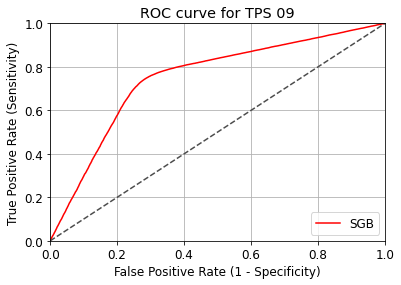

In [225]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_hat_002[:,1])
plot_roc_curve(fpr, tpr, label="SGB")
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando o gráfico acima, podemos concluir que o melhor ponto de corte (threshold) fica em torno de .4 à .45, isto é, esse ponto de corte melhora o F1-score,  vamos fazer esse teste.  

</div>


- **SEM PONTO DE CORTE**

In [226]:
threshold = .5

f1_002  = metrics.f1_score (y_valid, (y_hat_002[:,1] > threshold))
auc_002 = metrics.roc_auc_score(y_valid, y_hat_002[:,1] )
print(metrics.classification_report(y_valid, (y_hat_002 > threshold)[:,1].astype(int) ))
print('')
print('F1-score: {:2.5f}'.format(f1_002))
print('AUC     : {:2.5f}'.format(auc_002))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     59279
           1       0.73      0.74      0.73     60721

    accuracy                           0.73    120000
   macro avg       0.73      0.73      0.73    120000
weighted avg       0.73      0.73      0.73    120000


F1-score: 0.73431
AUC     : 0.74797


- **COM PONTO DE CORTE**

In [253]:
threshold = .5
y_hat     = (y_hat_002[:,1] > threshold).astype(int)

f1_002  = metrics.f1_score (y_valid, y_hat )
auc_002 = metrics.roc_auc_score(y_valid, y_hat)
print(metrics.classification_report(y_valid, y_hat))
print('')
print('F1-score: {:2.5f}'.format(f1_002))
print('AUC     : {:2.5f}'.format(auc_002))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     59279
           1       0.73      0.74      0.73     60721

    accuracy                           0.73    120000
   macro avg       0.73      0.73      0.73    120000
weighted avg       0.73      0.73      0.73    120000


F1-score: 0.73431
AUC     : 0.73026


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Podemos observar acima, com um ponto de corte de .45 obtivemos um F1-score de 0.69162 em relação ao ponto de corte padrão de .5 que gerou um F1-score de 0.66127, uma observação importante que tenho que destacar é que o ponto de corte ideal depende muito do entendimento do negócio que estamos modelando.
 
</div>

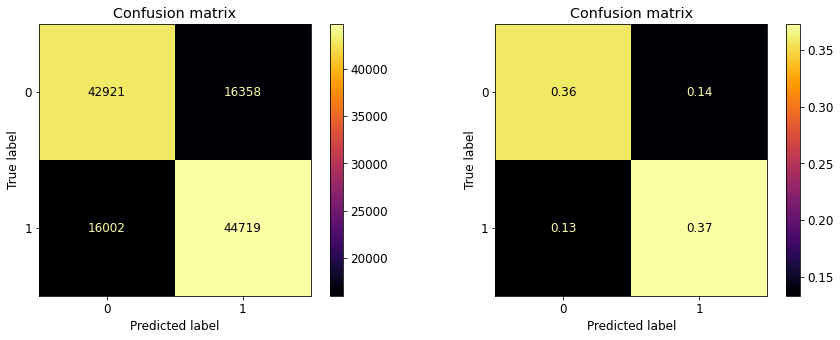

In [228]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)

metrics.plot_confusion_matrix(model_002, 
                              X_valid_scaler, 
                              y_valid, 
                              cmap          = 'inferno', 
                              values_format = 'd', 
                              ax            = ax) #true’, ‘pred’, ‘all’

plt.title('Confusion matrix')

ax= plt.subplot(1,2,2)
metrics.plot_confusion_matrix(model_002, X_valid_scaler, y_valid, cmap='inferno', normalize='all', ax=ax) 
plt.title('Confusion matrix');

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
com as matrizes de confusão acima podemos ter uma melhor noção para dos número que o modelo consegue gerar na predição, podemos obeservar que o modelo de Random Forest para esse conjunto de dados tem uma taxa razoavel na predição, principalmente na predição de verdadeiro positivo com um percentual de erro de 23%, isto é, o modelo classifica erradamente falsos positivos com sendo verdadeiro posito e acerta 33%, em relação ao falso positivo tem um erro de 17% com certo de 28%.
    
</div>

### 1.2.4. Divercidade

#### 1.2.4.1. Feature Select

In [229]:
k_vs_score  = []
num_feature = X_train.shape[1]
name_model  = name_model_clf + '006_feature_select'

TunningModels.delete_files(name_model)

mdl = SGDClassifier(**params_best) 

for k in range(2, num_feature, 2):

    selector         = SelectKBest(score_func=f_classif, k=k)
    X_train_selKBest = pd.DataFrame(selector.fit_transform(X, y))
    X_test_selKBest  = pd.DataFrame(selector.transform(X_test_scaler))    
    
    model_006, score, y_pre_test = TunningModels.cross_valid(model          = mdl, 
                                                             model_name_    = name_model, 
                                                             X_             = X_train_selKBest, 
                                                             y_             = y, 
                                                             X_test_        = X_test_selKBest,                                                              
                                                             feature        = None,
                                                             seed           = SEED,                                                                                
                                                             scaler         = sc,
                                                             save_predict   = True, 
                                                             print_result   = False
                                                             )
    
    print("k: {} => AUC: {:2.5F}".format(k, score))

    k_vs_score.append(score)

k: 2 => AUC: 0.60638
k: 4 => AUC: 0.62990
k: 6 => AUC: 0.65228
k: 8 => AUC: 0.66672
k: 10 => AUC: 0.68364
k: 12 => AUC: 0.69399
k: 14 => AUC: 0.70271
k: 16 => AUC: 0.70907
k: 18 => AUC: 0.71502
k: 20 => AUC: 0.71960
k: 22 => AUC: 0.72323
k: 24 => AUC: 0.72578
k: 26 => AUC: 0.72752
k: 28 => AUC: 0.72840
k: 30 => AUC: 0.72985
k: 32 => AUC: 0.73208
k: 34 => AUC: 0.73351
k: 36 => AUC: 0.73461
k: 38 => AUC: 0.73569
k: 40 => AUC: 0.73673
k: 42 => AUC: 0.73698
k: 44 => AUC: 0.73824
k: 46 => AUC: 0.73919
k: 48 => AUC: 0.74026
k: 50 => AUC: 0.74083
k: 52 => AUC: 0.74129
k: 54 => AUC: 0.74208
k: 56 => AUC: 0.74273
k: 58 => AUC: 0.74329
k: 60 => AUC: 0.74343
k: 62 => AUC: 0.74383
k: 64 => AUC: 0.74375
k: 66 => AUC: 0.74412
k: 68 => AUC: 0.74462
k: 70 => AUC: 0.74493
k: 72 => AUC: 0.74529
k: 74 => AUC: 0.74547
k: 76 => AUC: 0.74561
k: 78 => AUC: 0.74595
k: 80 => AUC: 0.74613
k: 82 => AUC: 0.74668
k: 84 => AUC: 0.74674
k: 86 => AUC: 0.74694
k: 88 => AUC: 0.74702
k: 90 => AUC: 0.74711
k: 92 => AUC: 

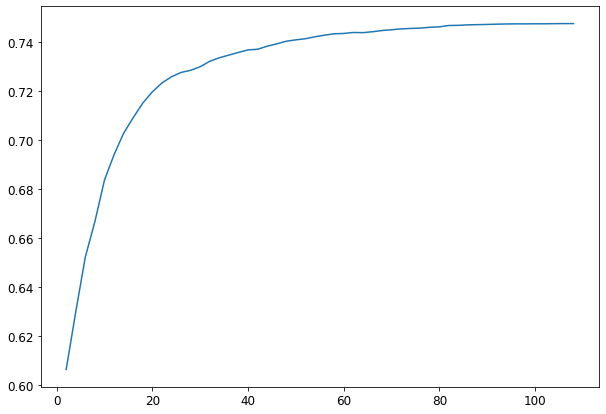

In [232]:
pd.Series(k_vs_score, index=range(2,X_train.shape[1],2)).plot(figsize=(10,7));

In [233]:
selector = SelectKBest(score_func=f_classif, k=70)
selector.fit(X_train, y_train)

SelectKBest(k=70)

In [238]:
selector

SelectKBest(k=70)

In [234]:
mask = selector.get_support()
feature_select = X_train.iloc[:, mask].columns.to_list()

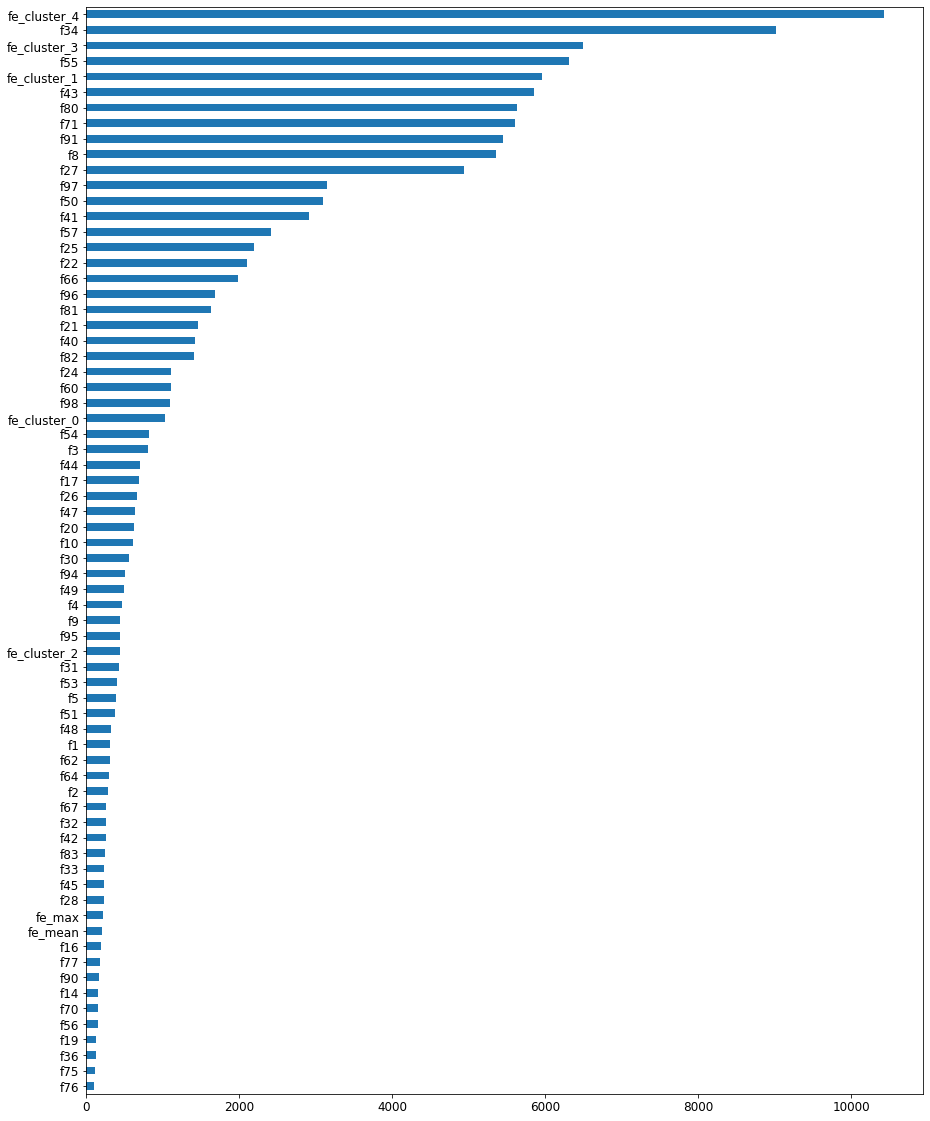

In [239]:
plt.figure(figsize=(15,20))
pd.Series(selector.scores_, index=X_train.columns).sort_values().tail(70).plot.barh();

#### 1.2.4.1. SEED
Nesta etapa vamos utilizar os melhores parametros, que encontramos na tunagem acima, com `seed` diferentes. 

In [230]:
%%time 

SEED_       = [42, 59, 100, 200, 1000, 1500, 2020, 2021, 5000, 10000, 12359 ]
name_model  = name_model_clf + '005_div_seed'
df_seed     = pd.DataFrame()
seed_best   = seed_best
score_best  = 0 
params_seed = params_best.copy()

TunningModels.delete_files(name_model)


mdl = SGDClassifier(**params_best) 

for i, seed_ in  enumerate (SEED_):     
    
    params_seed.update({'random_state': seed_})

    _, score , y_hat = TunningModels.cross_valid(model          = mdl,  
                                                 model_name_    = name_model, 
                                                 X_             = X, 
                                                 y_             = y, 
                                                 X_test_        = X_test_scaler, 
                                                 type_model     = 1, 
                                                 feature        = None,
                                                 seed           = seed_, 
                                                 tunning        = 2, # 
                                                 scaler         = sc, 
                                                 save_predict   = True
                                                 )
        
    if score > score_best: 
        seed_best  = seed_
        score_best = score

    df_seed['seed_' + str(seed_)] = y_hat 
   
print('Seed best: {}'.format(seed_best))
print('Score    : {:2.5f}'.format(score_best))

Training model: SGDClassifier seed 42 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
Fold 1/5 AUC: 0.74915 - F1: 0.63529 - L. loss: 0.81474   1     0h 0m 12s
Fold 2/5 AUC: 0.74956 - F1: 0.46352 - L. loss: 1.12556   1     0h 0m 12s
Fold 3/5 AUC: 0.74730 - F1: 0.32498 - L. loss: 1.44435   1     0h 0m 12s
Fold 4/5 AUC: 0.74759 - F1: 0.69652 - L. loss: 1.18865   1     0h 0m 12s
Fold 5/5 AUC: 0.74511 - F1: 0.46253 - L. loss: 1.09825   1     0h 0m 14s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74774(Std:0.00158) - F1: 0.51657 - L. Loss: 1.13431 * 1 0h 1m 18s

Training model: SGDClassifier seed 59 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
Fold 1/5 AUC: 0.74816 - F1: 0.59562 - L. loss: 0.85645   1     0h 0m 12s
Fold 2/5 AUC: 0.74833 - F1: 0.72510 - L. loss: 0.76534   1     0h 0m 12s
Fold 3/5 AUC: 0.74673 - F1: 0.43852 - L. loss: 1.11828   1     0h 0m 13s
Fold 4/5 AUC: 0.74602 - F1: 0.34660 - L. loss: 1.42805  

----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74747(Std:0.00093) - F1: 0.64569 - L. Loss: 0.85882 * 1 0h 1m 21s

Training model: SGDClassifier seed 10000 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
Fold 1/5 AUC: 0.74605 - F1: 0.52801 - L. loss: 0.96746   1     0h 0m 14s
Fold 2/5 AUC: 0.74839 - F1: 0.73107 - L. loss: 0.77106   1     0h 0m 13s
Fold 3/5 AUC: 0.74730 - F1: 0.73866 - L. loss: 0.73853   1     0h 0m 13s
Fold 4/5 AUC: 0.74827 - F1: 0.39311 - L. loss: 1.25411   1     0h 0m 14s
Fold 5/5 AUC: 0.74745 - F1: 0.48531 - L. loss: 0.99375   1     0h 0m 14s
----------------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.74749(Std:0.00084) - F1: 0.57523 - L. Loss: 0.94498 * 1 0h 1m 24s

Training model: SGDClassifier seed 12359 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
Fold 1/5 AUC: 0.74558 - F1: 0.51146 - L. loss: 0.97956   1     0h 0m 12s
Fold 2/5

In [236]:
 df_seed.head()

,seed_42,seed_59,seed_100,seed_200,seed_1000,seed_1500,seed_2020,seed_2021,seed_5000,seed_10000,seed_12359
0,0.554407,0.541155,0.514359,0.576736,0.533809,0.546888,0.563893,0.516517,0.565402,0.569756,0.532919
1,0.538987,0.520527,0.479898,0.537832,0.496073,0.523662,0.539426,0.504510,0.549122,0.540153,0.507684
2,0.704748,0.700788,0.647878,0.697504,0.667615,0.688181,0.711358,0.655269,0.707348,0.707761,0.687231
3,0.383504,0.355730,0.342406,0.382940,0.346044,0.363745,0.397098,0.349695,0.385820,0.390442,0.360871
4,0.468867,0.462363,0.423970,0.467968,0.445082,0.451747,0.469408,0.421819,0.486495,0.465304,0.459281


In [237]:
submission = pd.DataFrame({'id': df_submission.id, target: df_seed.sum(axis=1)})
submission.to_csv(path + 'Data/submission/logr_005_div_seed.csv', index=False)
# kaggle 0.74514

In [254]:
feature_best = pd.Series(selector.scores_, index=X_train.columns).sort_values().tail(80).index.to_list()

In [ ]:
name_model  = name_model_clf + '006_features_best_seeed'

TunningModels.delete_files(name_model)

mdl, score , y_hat = TunningModels.cross_valid(model          = mdl,  
                                             model_name_    = name_model, 
                                             X_             = X, 
                                             y_             = y, 
                                             X_test_        = X_test_scaler, 
                                             type_model     = 1, 
                                             feature        = feature_best,
                                             seed           = seed_best, 
                                             tunning        = 2, # 
                                             scaler         = sc, 
                                             save_predict   = True
                                             )

Training model: SGDClassifier seed 100 - n_estimators: 1 - max_iter: 926 - 1.00000 - 1
